# Grover's Algorithm

In [1]:
from qiskit import *
from qiskit.compiler import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_textbook.tools import *
from qiskit.quantum_info import Operator
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
qasm_simulator = Aer.get_backend('qasm_simulator')
statevector_simulator = Aer.get_backend('statevector_simulator')
unitary_simulator = Aer.get_backend('unitary_simulator')

# Review of Grover's Algorithm

![image](resources/grover_blockdiagram.png)

Please note

- In these exercises, we implement the phase oracle and diffuser as matrices without decomposing them into single- and two-qubit gates. 
- To run on real hardware, one will also need to consider how to build these oracles using gates. 

**Grover's Algorithm**

The Grover's algorithm has three main components. 
1. First, we begin by creating a superposition of all $2^n$ computational basis states by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. Here, the exponent $\otimes n$ means that we have a tensor product of the states of $n$ qubits. 
2. Second, we apply an Oracle operator to mark the appropriate elements among the $2^n$ elements. The oracle operator applies a coefficient of $-1$ to each of the marked elements.
3. Third, we apply a Diffusion operator, or diffuser, which inverts the amplitude of all elements about the average amplitude.

- Putting these components together, and applying the Oracle and Diffusion operators $O(\sqrt{N = 2^n})$ times, Grover's algorithm allows us to successfully determine the elements that were marked by the Oracle operator with high probability. 
- This is shown in the block diagram above, where the quantum circuit for Grover's algorithm is depicted with a measurement in the end to read out the qubits.

In [3]:
n = 2 # Number of Qubits
indices_of_marked_elements = [1]

Here, we would implement Grover's algorithm by creating a quantum circuit that has the one or more marked elements. We would like the algorithm to outputs one of the marked elements with probability greater than $99\%$. 

### 1.) Phase Oracle

**Recall that the action of the phase oracle is to add a phase of $-1$ to all states representing the marked elements, while leaving all other states unchanged.** 

- An easy way to implement the phase oracle is to create an identity matrix on all $n$ qubits (remember that the corresponding dimension of this matrix is $2^n$). 
- Then, change those diagonal elements to $-1$ that correspond to the marked elements. 
- Then, we need to convert that unitary into an operator.

The function `phase_oracle` defined below, takes in two arguments. 

- The first argument, $n$, gives the number of qubits in the quantum circuit. 
- The second argument, `indices_to_mark`, is a list of the indices whose elements will be marked by the phase oracle with a phase of $-1$. 
- Using these inputs, create a $2^n\times2^n$ identity matrix, and apply a phase of $-1$ to the diagonal elements at locations given in `indices_to_mark`. 
- For example, if $0$ is in `indices_to_mark`, that means weneed to set the top-left-most diagonal element of the identity matrix to -1.

Once we complete these steps, apply the unitary operator to the quantum circuit.

In [4]:
def phase_oracle(n, indices_to_mark, name = 'Oracle'):
    
    # create a quantum circuit on n qubits
    qc = QuantumCircuit(n, name=name)
    
    # create the identity matrix on n qubits
    oracle_matrix = np.identity(2**n)
    
    # add the -1 phase to marked elements
    for index_to_mark in indices_to_mark:
        oracle_matrix[index_to_mark, index_to_mark] = -1    
    
    # convert your matrix (called oracle_matrix) into an operator, and add it to the quantum circuit
    qc.unitary(Operator(oracle_matrix), range(n))
    
    return qc

In [5]:
def phase_oracle_explained(n, indices_to_mark, name = 'Oracle'):
    
    # create a quantum circuit on n qubits
    qc = QuantumCircuit(n, name=name)
    
    # create the identity matrix on n qubits
    oracle_matrix = np.identity(2**n)
    print(oracle_matrix, end="\n----\n")
    
    # add the -1 phase to marked elements
    for index_to_mark in indices_to_mark:# [1]
        oracle_matrix[index_to_mark, index_to_mark] = -1
    print(oracle_matrix, end="\n----\n")    
    
    print(Operator(oracle_matrix), end="\n----\n")
    
    # convert your matrix (called oracle_matrix) into an operator, and add it to the quantum circuit
    qc.unitary(Operator(oracle_matrix), range(n))
    
    return qc

In [6]:
qc = phase_oracle_explained(n, indices_of_marked_elements)
qc.draw()
# No. of qubits =  n
# N = 2 **n(No. of superposition states)
# Each column represents a superposition state

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
----
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]
----
Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
----


┌──────────┐
q_0: ┤0         ├
     │  unitary │
q_1: ┤1         ├
     └──────────┘

### 2.) Diffusion Operator $V$

Next, we define the diffuser. 

- Its effect is to reflect all amplitudes about the average amplitude. 
- To do so, we simply call the `phase_oracle` with only the zero state ($\vert0\rangle^{\otimes n}$) as the marked element and sandwich it between Hadamard gates applied to all qubits.

In [7]:
def diffuser(n): # Mean + Mean - Amplitude
    
    # create a quantum circuit on n qubits
    qc = QuantumCircuit(n, name='Diffuser')
    
    # apply hadamard gates to all qubits
    qc.h(range(n))
    
    # call the phase oracle applied to the zero state
    qc.append(phase_oracle(n, [0]), range(n))
    
    # apply hadamard gates to all qubits
    qc.h(range(n))
    
    return qc

In [8]:
diffuser_circuit = diffuser(n)
diffuser_circuit.draw()

┌───┐┌─────────┐┌───┐
q_0: ┤ H ├┤0        ├┤ H ├
     ├───┤│  Oracle │├───┤
q_1: ┤ H ├┤1        ├┤ H ├
     └───┘└─────────┘└───┘

### 3.) Putting it all together

Finally, we combine the functions to construct Grover's algorithm. We need to determine the optimal number of rounds $r$ as described in the lecture.

This was given by 

$$r = \left\lfloor\frac{\pi}{4}\sqrt{\frac{N}{k}}\right\rfloor$$

where $k$ is the number of marked elements, and $\lfloor~\rfloor$ means rounding down to the nearest integer.
Here,
- n = number of qubits
- $N = 2^n$
- $k$ = number of marked elements


Let's construct a quantum program that finds the marked elements using Grover's algorithm. To do this, we will need to do the following: 
1. We start with a Hadamard gate on all qubits.
2. Next, we apply $r$ rounds of Grover's algorithm, where each round consists of the application of the phase oracle with the marked elements and the diffuser.
3. Finally, we need to measure all qubits.

In [9]:
def Grover(n, indices_of_marked_elements, r=0):
    
    # Create a quantum circuit on n qubits
    qc = QuantumCircuit(n, n)
    
    # Determine r
    if r == 0:
        r = int(np.floor(np.pi/4*np.sqrt(2**n/len(indices_of_marked_elements))))
        print(f'{n} qubits, basis states {indices_of_marked_elements} marked, {r} rounds')
    
    # step 1: apply Hadamard gates on all qubits
    qc.h(range(n))
    
    # step 2: apply r rounds of the phase oracle and the diffuser
    for _ in range(r):
        qc.append(phase_oracle(n, indices_of_marked_elements), range(n))
        qc.append(diffuser(n), range(n))
        
    # step 3: measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

In [10]:
circuit = Grover(n, indices_of_marked_elements, 1)
circuit.draw()

┌───┐┌─────────┐┌───────────┐┌─┐   
q_0: ┤ H ├┤0        ├┤0          ├┤M├───
     ├───┤│  Oracle ││  Diffuser │└╥┘┌─┐
q_1: ┤ H ├┤1        ├┤1          ├─╫─┤M├
     └───┘└─────────┘└───────────┘ ║ └╥┘
c: 2/══════════════════════════════╩══╩═
                                   0  1

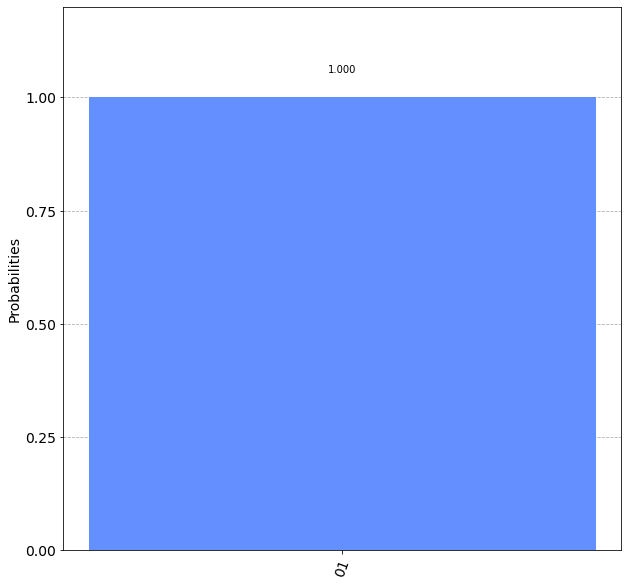

In [11]:
counts = execute(circuit, backend=qasm_simulator, shots=1000).result().get_counts(circuit)
plot_histogram(counts, figsize=(10,10))

In [12]:
transpiled_qc = transpile(circuit, qasm_simulator)

In [13]:
transpiled_qc.draw()

┌───┐┌──────────┐┌───┐┌──────────┐┌───┐┌─┐   
q_0: ┤ H ├┤0         ├┤ H ├┤0         ├┤ H ├┤M├───
     ├───┤│  unitary │├───┤│  unitary │├───┤└╥┘┌─┐
q_1: ┤ H ├┤1         ├┤ H ├┤1         ├┤ H ├─╫─┤M├
     └───┘└──────────┘└───┘└──────────┘└───┘ ║ └╥┘
c: 2/════════════════════════════════════════╩══╩═
                                             0  1

In [14]:
qobj = assemble(transpiled_qc)
final_state = statevector_simulator.run(qobj).result().get_statevector()
array_to_latex(final_state)

<IPython.core.display.Math object>

## Round 1 Explaination

## 1) Initial State

In [15]:
qc = QuantumCircuit(n)
qc.h(range(n))
qc.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [16]:
qobj = assemble(qc)
final_state = statevector_simulator.run(qobj).result().get_statevector()
array_to_latex(final_state)

<IPython.core.display.Math object>

## 2) Phase Inversion

In [17]:
def Grover_Step_I(n, indices_of_marked_elements, r=0):
    
    # Create a quantum circuit on n qubits
    qc = QuantumCircuit(n)
    
    # Determine r
    if r == 0:
        r = int(np.floor(np.pi/4*np.sqrt(2**n/len(indices_of_marked_elements))))
        print(f'{n} qubits, basis states {indices_of_marked_elements} marked, {r} rounds')
    
    # step 1: apply Hadamard gates on all qubits
    qc.h(range(n))
    
    # step 2: apply r rounds of the phase oracle and the diffuser
    for _ in range(r):
        qc.append(phase_oracle(n, indices_of_marked_elements), range(n))
        #qc.append(diffuser(n), range(n))
        
    # step 3: measure all qubits
    #qc.measure(range(n), range(n))
  
    return qc

In [18]:
qc = Grover_Step_I(n, indices_of_marked_elements, 1)
qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤0        ├
     ├───┤│  Oracle │
q_1: ┤ H ├┤1        ├
     └───┘└─────────┘

In [19]:
transpiled_qc = transpile(qc, qasm_simulator)
transpiled_qc.draw()

┌───┐┌──────────┐
q_0: ┤ H ├┤0         ├
     ├───┤│  unitary │
q_1: ┤ H ├┤1         ├
     └───┘└──────────┘

In [20]:
qobj = assemble(transpiled_qc)
final_state = statevector_simulator.run(qobj).result().get_statevector()
array_to_latex(final_state)

<IPython.core.display.Math object>

## 3) Amplitude Amplification

In [21]:
def Grover_Step_II(n, indices_of_marked_elements, r=0):
    
    # Create a quantum circuit on n qubits
    qc = QuantumCircuit(n)
    
    # Determine r
    if r == 0:
        r = int(np.floor(np.pi/4*np.sqrt(2**n/len(indices_of_marked_elements))))
        print(f'{n} qubits, basis states {indices_of_marked_elements} marked, {r} rounds')
    
    # step 1: apply Hadamard gates on all qubits
    qc.h(range(n))
    
    # step 2: apply r rounds of the phase oracle and the diffuser
    for _ in range(r):
        qc.append(phase_oracle(n, indices_of_marked_elements), range(n))
        qc.append(diffuser(n), range(n))
        
    # step 3: measure all qubits
    #qc.measure(range(n), range(n))
  
    return qc

In [22]:
qc = Grover_Step_II(n, indices_of_marked_elements, 1)
qc.draw()

┌───┐┌─────────┐┌───────────┐
q_0: ┤ H ├┤0        ├┤0          ├
     ├───┤│  Oracle ││  Diffuser │
q_1: ┤ H ├┤1        ├┤1          ├
     └───┘└─────────┘└───────────┘

In [23]:
transpiled_qc = transpile(qc, qasm_simulator)
transpiled_qc.draw()

┌───┐┌──────────┐┌───┐┌──────────┐┌───┐
q_0: ┤ H ├┤0         ├┤ H ├┤0         ├┤ H ├
     ├───┤│  unitary │├───┤│  unitary │├───┤
q_1: ┤ H ├┤1         ├┤ H ├┤1         ├┤ H ├
     └───┘└──────────┘└───┘└──────────┘└───┘

In [24]:
qobj = assemble(transpiled_qc)
final_state = statevector_simulator.run(qobj).result().get_statevector()
array_to_latex(final_state)

<IPython.core.display.Math object>